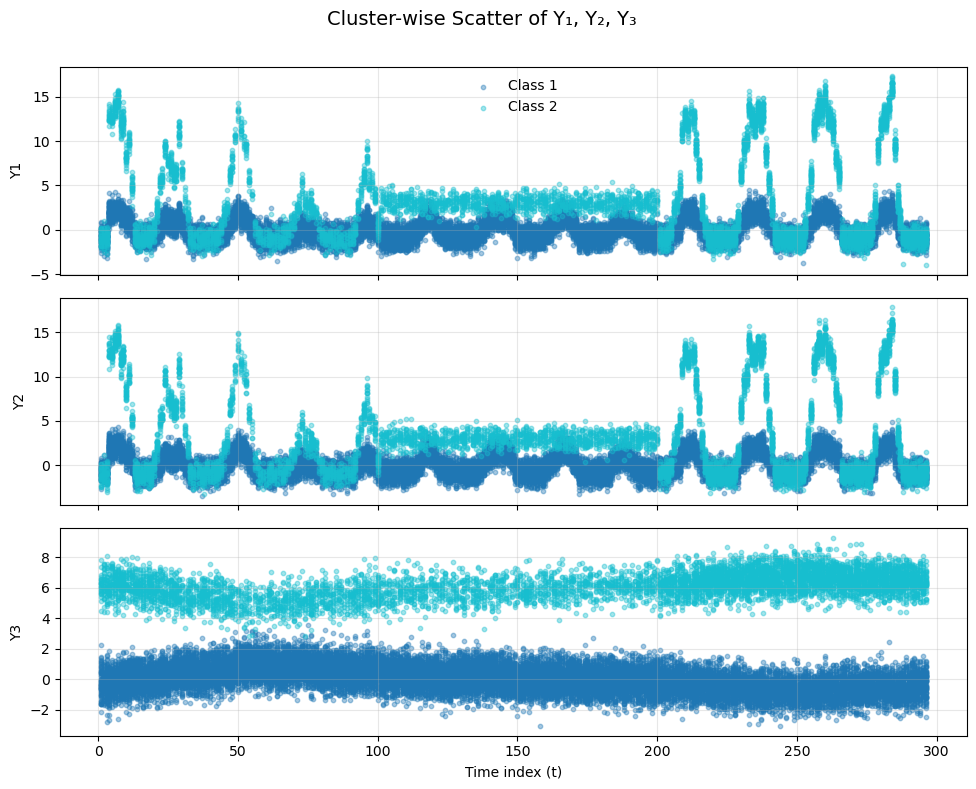

In [1]:
import torch, random, io, sys, warnings
import os, numpy as np, pandas as pd, pyreadr, matplotlib.pyplot as plt
from scipy.special import softmax
from data_generator import generate_gmm_data_segments
from tqdm import tqdm
from cpd_model import parse_args, learn_one_seq_penalty


os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"


import pyreadr


Y = pyreadr.read_r("./real_data_sim/sim_dat_ult_5_1.RDS")

X = pyreadr.read_r("./real_data_sim/sim_x_ult_5_1.RDS")

Y_df = np.array(list(Y.values())[0])
X_df = np.array(list(X.values())[0])

X_rep = np.repeat(X_df[:, np.newaxis, :], 100, axis=1)
Y = Y_df[:,:,0:3]
X = X_rep

import numpy as np
import matplotlib.pyplot as plt

T = Y_df.shape[0]
labels = np.unique(Y_df[:, :, 3].astype(int))
colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
dims = ['Y1', 'Y2', 'Y3']

for d in range(3):
    ax = axes[d]
    for j, lab in enumerate(labels):
        mask = (Y_df[:, :, 3] == lab)
        Y_vals = np.where(mask, Y_df[:, :, d], np.nan)
        t_vals = np.repeat(np.arange(1, T + 1)[:, None], Y_df.shape[1], axis=1)
        ax.scatter(t_vals[mask], Y_vals[mask],
                   color=colors[j], alpha=0.4, s=10, label=f"Class {lab}" if d == 0 else None)
    ax.set_ylabel(dims[d])
    ax.grid(True, alpha=0.3)
    if d == 2:
        ax.set_xlabel("Time index (t)")

axes[0].legend(frameon=False)
fig.suptitle("Cluster-wise Scatter of Y₁, Y₂, Y₃", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()





In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

# ======================================================
# 7. Prepare args
# ======================================================
args = parse_args()
args.epoch = 150
args.K_dim = 2
args.z_dim = 3
args.x_dim = X.shape[2]
args.y_dim = Y.shape[2]
args.num_time = X.shape[0]
args.num_samples = X.shape[1]
args.decoder_lr = 0.01
args.decoder_iteration = 20
args.langevin_s = 0.2
args.langevin_K = 100
args.kappa = 0.8
args.penalties = [0.01, 0.05, 0.1, 1]
args.nu_iteration = 20
args.output_layer = [50, 50]
args.scale_delta = False
args.signif_level = 0.9999
args.true_CP_full = [100,200]

# ======================================================
# 8. Prepare data tensors
# ======================================================


X_flat = X.reshape(-1, args.x_dim)
# X_mean, X_std = X_flat.mean(axis=0, keepdims=True), X_flat.std(axis=0, keepdims=True) + 1e-8
# X_flat = (X_flat - X_mean) / X_std
X_array = X_flat.reshape(args.num_time, -1, args.x_dim)

x_input = torch.tensor(X_array, dtype=torch.float32).to(device)
y_input = torch.tensor(Y.reshape(args.num_time, -1, args.y_dim), dtype=torch.float32).to(device)

# Split odd/even for penalty selection
odd_idx, even_idx = range(1, args.num_time, 2), range(0, args.num_time, 2)
x_train, x_test = x_input[odd_idx].reshape(-1, args.x_dim), x_input[even_idx].reshape(-1, args.x_dim)
y_train, y_test = y_input[odd_idx].reshape(-1, args.y_dim), y_input[even_idx].reshape(-1, args.y_dim)

# ======================================================
# 9. Penalty selection (half training)
# ======================================================
# results_half = []
# for penalty in args.penalties:
#     _stdout = sys.stdout
#     sys.stdout = io.StringIO()  # suppress printing
#     try:
#         loss, pen = learn_one_seq_penalty(args, x_train, y_train, x_test, y_test, penalty=penalty, half=True)
#     finally:
#         sys.stdout = _stdout
#     results_half.append([loss, pen])

# results_half = np.array(results_half)
# best_idx = np.argmin(results_half[:, 0])
# best_penalty = args.penalties[best_idx]
# print(f"[INFO] Best penalty selected = {best_penalty}")

# ======================================================
# 10. Full training using best penalty (record Kurtosis)
# ======================================================
result, kurt_list, delta_mu_all = learn_one_seq_penalty(
    args,
    x_input.reshape(-1, args.x_dim),
    y_input.reshape(-1, args.y_dim),
    x_input.reshape(-1, args.x_dim),
    y_input.reshape(-1, args.y_dim),
    penalty=0.1,
    half=False
)
torch.cuda.empty_cache()

# ======================================================
# 11. Plot Kurtosis trajectory
# ======================================================
import matplotlib.pyplot as plt
epochs = np.arange(1, len(kurt_list) + 1)
best_idx_kurt = int(np.argmax(kurt_list))
best_kurt = kurt_list[best_idx_kurt]

plt.figure(figsize=(7, 4))
plt.plot(epochs, kurt_list, marker='o', lw=1.8, label='Kurtosis trajectory')
plt.axvline(best_idx_kurt + 1, color='red', linestyle='--', lw=1.2,
            label=f'Max Kurtosis epoch = {best_idx_kurt + 1}')
plt.scatter(best_idx_kurt + 1, best_kurt, color='red', s=60, zorder=5)
plt.title("Kurtosis Evolution During Training", fontsize=13)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Kurtosis(Δμ)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

print(f"[INFO] Best epoch (max Kurtosis): {best_idx_kurt + 1}, Kurtosis = {best_kurt:.6f}")

# ======================================================
# 12. Report results
# ======================================================
print(f"\n[RESULT] True CPs = {args.true_CP_full}")
print(f"[RESULT] Detected CPs = {result[5]}")
print(f"[RESULT] Covering metric = {result[3]:.4f}")
print(f"[RESULT] abs_error = {result[0]:.4f}")


import matplotlib.pyplot as plt


epochs_to_show = [200]
plt.figure(figsize=(10, 5))

for e in epochs_to_show:
    if e <= len(delta_mu_all):
        plt.plot(delta_mu_all[e-1], lw=1.6, label=f"Epoch {e}, SNR={kurt_list[e-1]:.2f}")
for cp in [100,200]:
    plt.axvline(x=cp-1, color='red', linestyle='--', lw=1.5, label='True CP')
plt.xlabel("Time index (t)")
plt.ylabel("‖μₜ - μₜ₋₁‖₂ (Δμ)")
plt.title("Δμ evolution across different epochs")
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()



In [ ]:
# Repeat 50 times

import torch, random, io, sys, warnings
import os, numpy as np, pandas as pd, pyreadr
from tqdm import tqdm
from cpd_model import parse_args, learn_one_seq_penalty

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

# ======================================================
# 0. Config
# ======================================================
REPS = 50
TRUE_CP = [100, 200]

# ======================================================
# 1. Prepare args template
# ======================================================
args = parse_args()
args.epoch = 150
args.K_dim = 2
args.z_dim = 3
args.decoder_lr = 0.01
args.decoder_iteration = 20
args.langevin_s = 0.2
args.langevin_K = 100
args.kappa = 0.8
args.penalties = [0.01, 0.05, 0.1, 1]
args.nu_iteration = 20
args.output_layer = [50, 50]
args.scale_delta = False
args.signif_level = 0.99
args.true_CP_full = TRUE_CP

# ======================================================
# 2. Run 50 replicates
# ======================================================
records = []
GLOBAL_SEED = 1
for rep in range(1, REPS + 1):
    print(f"\n===== Running replicate {rep} / {REPS} =====")
    SEED = GLOBAL_SEED
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # -------------------------------
    # (1) Load Data
    # -------------------------------
    Y = pyreadr.read_r(f"./real_data_sim/sim_dat_ult_5_{rep}.RDS")
    X = pyreadr.read_r(f"./real_data_sim/sim_x_ult_5_{rep}.RDS")
    Y_df = np.array(list(Y.values())[0])
    X_df = np.array(list(X.values())[0])

    X_rep = np.repeat(X_df[:, np.newaxis, :], 100, axis=1)
    Y = Y_df[:, :, 0:3]
    X = X_rep

    args.num_time = X.shape[0]
    args.num_samples = X.shape[1]
    args.x_dim = X.shape[2]
    args.y_dim = Y.shape[2]

    x_input = torch.tensor(X, dtype=torch.float32).to(device)
    y_input = torch.tensor(Y, dtype=torch.float32).to(device)


    odd_idx, even_idx = range(1, args.num_time, 2), range(0, args.num_time, 2)
    x_train, x_test = x_input[odd_idx].reshape(-1, args.x_dim), x_input[even_idx].reshape(-1, args.x_dim)
    y_train, y_test = y_input[odd_idx].reshape(-1, args.y_dim), y_input[even_idx].reshape(-1, args.y_dim)


    results_half = []
    for penalty in args.penalties:
        _stdout = sys.stdout
        sys.stdout = io.StringIO()
        try:
            loss, pen = learn_one_seq_penalty(args, x_train, y_train, x_test, y_test, penalty=penalty, half=True)
        finally:
            sys.stdout = _stdout
        results_half.append([loss, pen])

    results_half = np.array(results_half)
    best_idx = np.argmin(results_half[:, 0])
    best_penalty = args.penalties[best_idx]
    print(f"[INFO] Best penalty for replicate {rep}: {best_penalty}")

    _stdout = sys.stdout
    sys.stdout = io.StringIO()
    try:
        result, kurt_list, delta_mu_all = learn_one_seq_penalty(
            args,
            x_input.reshape(-1, args.x_dim),
            y_input.reshape(-1, args.y_dim),
            x_input.reshape(-1, args.x_dim),
            y_input.reshape(-1, args.y_dim),
            penalty=best_penalty,
            half=False
        )
    finally:
        sys.stdout = _stdout
    torch.cuda.empty_cache()


    est_cp = np.array(result[5], dtype=int) if len(result[5]) > 0 else np.array([])
    true_cp = np.array(TRUE_CP)
    T = args.num_time
    tol = 10

    if len(est_cp) == 0:
        cover_rate = 0
        avg_dist = np.nan
        FP = 0
        FN = len(true_cp)
    else:
        dist_mat = np.abs(est_cp[:, None] - true_cp[None, :])
        min_dist_true = dist_mat.min(axis=0)
        min_dist_est = dist_mat.min(axis=1)
        cover_rate = np.mean(min_dist_true <= tol)
        avg_dist = np.mean(min_dist_true)
        FP = np.sum(min_dist_est > tol)
        FN = np.sum(min_dist_true > tol)


    record = {
        "rep": rep,
        "abs_error": result[0],
        "precision": result[1],
        "recall": result[2],
        "cover_rate": cover_rate,
        "avg_dist": avg_dist,
        "FP": int(FP),
        "FN": int(FN),
        "f1_score": result[4],
        "est_CP": str(list(est_cp)),
        "best_penalty": best_penalty,
        "num_detected": len(est_cp),
        "method": "cpd_nn",
        "model_result": result 
    }
    records.append(record)


df_results = pd.DataFrame(records)
print("\n===== Summary of all replicates =====")
print(df_results.head())


summary = df_results[["cover_rate", "avg_dist", "FP", "FN", "abs_error", "precision", "recall", "f1_score"]].mean()
print("\n===== Average performance across all replicates =====")
print(summary)


df_results.to_csv("cpd_nn_results_summary.csv", index=False)


In [9]:
import pandas as pd
import ast
import re
import numpy as np

df_py = pd.read_csv("cpd_nn_results_summary.csv")

def clean_model_result(s):
    if pd.isna(s):
        return "()"
    s = re.sub(r"<Figure[^>]*>", "'FIGURE_OBJECT'", s)
    return s

df_py["model_result"] = df_py["model_result"].apply(clean_model_result)
df_py["model_result"] = df_py["model_result"].apply(ast.literal_eval)


df_py["abs_error"] = df_py["model_result"].apply(lambda x: x[0] if len(x) > 0 else np.nan)
df_py["covering_metric"] = df_py["model_result"].apply(lambda x: x[3] if len(x) > 3 else np.nan)
df_py["dist_est_gt"] = df_py["model_result"].apply(lambda x: x[1] if len(x) > 1 else np.nan)
df_py["dist_gt_est"] = df_py["model_result"].apply(lambda x: x[2] if len(x) > 2 else np.nan)


df_py_clean = df_py[["method", "FP", "FN", "abs_error", "dist_est_gt", "dist_gt_est", "covering_metric"]]

df_py_clean["method"] = df_py_clean["method"].astype(str)
print(df_py_clean.head())

df_r = pd.read_csv("../sims_R/R_sims_summary.csv")
required_cols = [
    "method", "FP", "FN", "abs_error",
    "dist_est_gt", "dist_gt_est", "covering_metric"
]

for col in required_cols:
    if col not in df_r.columns:
        df_r[col] = np.nan

df_r_clean = df_r[required_cols].copy()
df_r_clean["method"] = df_r_clean["method"].astype(str)

print("[INFO] R results shape:", df_r_clean.shape)

df_combined = pd.concat([df_r_clean, df_py_clean], ignore_index=True)
df_combined.to_csv("combined_clean_results.csv", index=False)



   method  FP  FN  abs_error  dist_est_gt  dist_gt_est  covering_metric
0  cpd_nn   0   0          0            0            0         1.000000
1  cpd_nn   0   0          0            0            0         1.000000
2  cpd_nn   0   0          0            0            0         1.000000
3  cpd_nn   0   0          0            0            0         1.000000
4  cpd_nn   1   0          1            0           74         0.915541
[INFO] R results shape: (200, 7)


C:\Users\Qi\AppData\Local\Temp\ipykernel_20492\3820540959.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_py_clean["method"] = df_py_clean["method"].astype(str)


In [10]:
import pandas as pd


df_combined = pd.read_csv("combined_clean_results.csv")


summary = (
    df_combined
    .groupby("method")[["FP", "FN", "dist_est_gt", "dist_gt_est", "abs_error", "covering_metric"]]
    .mean()
    .reset_index()
)

summary = pd.concat([
    summary[summary["method"] == "cpd_nn"],
    summary[summary["method"] != "cpd_nn"]
]).reset_index(drop=True)

print(summary)



   method    FP    FN  dist_est_gt  dist_gt_est  abs_error  covering_metric
0  cpd_nn  0.60  0.04         2.98        39.72       0.56         0.935455
1     bcp  3.92  1.00        95.88        96.64       2.92         0.458633
2      bp  1.00  1.00        47.12        47.12       0.00         0.696282
3     ecp  1.20  0.92        12.10        18.32       0.28         0.893389
4  nonpar  1.04  0.04         8.80        58.52       1.00         0.795536
